In [3]:
# %%
import os
import pandas as pd
import numpy as np
import re

from utils.config import GRAPH_SAVE_FOLDER, DATA_FOLDER

# Load downlink data
data_dir = os.path.join(DATA_FOLDER)
extra_tag_down = "starlink_downlink"
tagged_folder_down = os.path.join(GRAPH_SAVE_FOLDER, extra_tag_down)
os.makedirs(tagged_folder_down, exist_ok=True)

df_downlink = pd.read_csv('./data/Satellite_Australia_Simulation_Log_starlink_downlink.csv')

# Load uplink data
extra_tag_up = "starlink_uplink"
tagged_folder_up = os.path.join(GRAPH_SAVE_FOLDER, extra_tag_up)
os.makedirs(tagged_folder_up, exist_ok=True)

df_uplink = pd.read_csv('./data/Satellite_Australia_Simulation_Log_starlink_uplink.csv')

# %%
# Drop columns that are all zero or NaN
def clean_df(df):
    return df.drop(columns=[col for col in df.columns if ((df[col] == 0) | (df[col].isna())).all()])

df_downlink = clean_df(df_downlink)
df_uplink = clean_df(df_uplink)

# %%
# Get all satellite IDs
def get_possible_sat_ids(df):
    sat_ids = [int(match.group(1)) for col in df.columns if (match := re.match(r'LEO(\d+)_', col))]
    return list(sorted(set(sat_ids)))

sat_ids_downlink = get_possible_sat_ids(df_downlink)
sat_ids_uplink = get_possible_sat_ids(df_uplink)
common_sat_ids = list(sorted(set(sat_ids_downlink).intersection(sat_ids_uplink)))

# Filter satellites that have access to both Sydney and Melbourne
def filter_dual_access(df, sat_ids):
    keep_ids = []
    for i in sat_ids:
        sat_id = f'LEO{i}'
        syd_access = f'{sat_id}_Sydney_Access'
        melb_access = f'{sat_id}_Melbourne_Access'

        syd_ok = syd_access in df.columns and df[syd_access].fillna(False).any()
        melb_ok = melb_access in df.columns and df[melb_access].fillna(False).any()

        if syd_ok and melb_ok:
            keep_ids.append(sat_id)
    return keep_ids

valid_sat_ids = filter_dual_access(df_downlink, common_sat_ids)

# Drop unrelated satellite columns
def keep_only_valid_sats(df, valid_sat_ids):
    keep_cols = ['Time']
    for col in df.columns:
        match = re.match(r'(LEO\d+)_', col)
        if match:
            if match.group(1) in valid_sat_ids:
                keep_cols.append(col)
        else:
            if col == 'Time':
                keep_cols.append(col)
    return df[keep_cols]

# Drop unrelated satellite columns
df_downlink = keep_only_valid_sats(df_downlink, valid_sat_ids)
df_uplink = keep_only_valid_sats(df_uplink, valid_sat_ids)

# FIX: Drop duplicated 'Time' if it exists
df_downlink = df_downlink.loc[:, ~df_downlink.columns.duplicated()]
df_uplink = df_uplink.loc[:, ~df_uplink.columns.duplicated()]

# Merge on Time
df_combined = pd.merge(df_uplink, df_downlink, on='Time', suffixes=('_UL', '_DL'))


# %%
# Extract balanced satellite per timestep
def extract_balanced_best(df, sat_ids):
    results = []

    for idx, row in df.iterrows():
        best = {
            'SAT_ID': None,
            'SNR_MELB_UL': -np.inf,
            'SNR_SYD_DL': -np.inf,
            'min_snr': -np.inf,
            'snr_diff': np.inf
        }

        for sat_id in sat_ids:
            snr_melb = row.get(f'{sat_id}_Melbourne_SNR_dB_UL')
            snr_syd = row.get(f'{sat_id}_Sydney_SNR_dB_DL')

            if pd.notna(snr_melb) and pd.notna(snr_syd):
                min_snr = min(snr_melb, snr_syd)
                snr_diff = abs(snr_melb - snr_syd)

                if (min_snr > best['min_snr']) or (min_snr == best['min_snr'] and snr_diff < best['snr_diff']):
                    best.update({
                        'SAT_ID': sat_id,
                        'SNR_MELB_UL': snr_melb,
                        'SNR_SYD_DL': snr_syd,
                        'min_snr': min_snr,
                        'snr_diff': snr_diff
                    })

        if best['SAT_ID']:
            sid = best['SAT_ID']
            result = {
                'Time': row['Time'],
                'Best_SAT_ID': sid,
                'Melbourne_SNR_UL': best['SNR_MELB_UL'],
                'Sydney_SNR_DL': best['SNR_SYD_DL'],
                'Melbourne_Thrpt_UL': row.get(f'{sid}_Melbourne_Throughput_UL') / (1024 * 1024),
                'Sydney_Thrpt_DL': row.get(f'{sid}_Sydney_Throughput_DL') / (1024 * 1024),
                'Melbourne_BER_QPSK_UL': row.get(f'{sid}_Melbourne_BER_QPSK_UL'),
                'Sydney_BER_QPSK_DL': row.get(f'{sid}_Sydney_BER_QPSK_DL'),
                'Melbourne_Latency_UL': row.get(f'{sid}_Melbourne_Latency_UL') * 1000,
                'Sydney_Latency_DL': row.get(f'{sid}_Sydney_Latency_DL') * 1000,
            }
            results.append(result)

    return pd.DataFrame(results)

# %%
balanced_df = extract_balanced_best(df_combined, valid_sat_ids)

# %%
# Create final performance metrics
final_df = pd.DataFrame()
final_df['Time'] = balanced_df['Time']
final_df['Best_SAT_ID'] = balanced_df['Best_SAT_ID']
final_df['EndToEnd_Min_SNR_dB'] = balanced_df[['Melbourne_SNR_UL', 'Sydney_SNR_DL']].min(axis=1)
final_df['EndToEnd_SNR_Diff_dB'] = abs(balanced_df['Melbourne_SNR_UL'] - balanced_df['Sydney_SNR_DL'])
final_df['EndToEnd_Throughput_Mbps'] = balanced_df[['Melbourne_Thrpt_UL', 'Sydney_Thrpt_DL']].min(axis=1)
final_df['EndToEnd_BER_QPSK'] = balanced_df[['Melbourne_BER_QPSK_UL', 'Sydney_BER_QPSK_DL']].max(axis=1)
final_df['EndToEnd_Latency_ms'] = balanced_df['Melbourne_Latency_UL'] + balanced_df['Sydney_Latency_DL']

# %%
# Save results
final_df.to_csv("Balanced_EndToEnd_Starlink_Performance.csv", index=False)
print(final_df.head())


                   Time Best_SAT_ID  EndToEnd_Min_SNR_dB  \
0  10-Apr-2025 12:00:00       LEO35            -1.502024   
1  10-Apr-2025 12:00:30       LEO35             0.014226   
2  10-Apr-2025 12:01:00       LEO35             3.138661   
3  10-Apr-2025 12:01:30       LEO35             3.955374   
4  10-Apr-2025 12:02:00       LEO35             0.133902   

   EndToEnd_SNR_Diff_dB  EndToEnd_Throughput_Mbps  EndToEnd_BER_QPSK  \
0             10.791468                184.055200           0.117095   
1              9.793835                238.982391           0.078310   
2              0.141422                235.365395           0.021190   
3              0.405048                271.637348           0.012877   
4              2.063503                146.257209           0.075475   

   EndToEnd_Latency_ms  
0             6.116335  
1             6.054165  
2             6.256142  
3             6.713981  
4             7.401217  


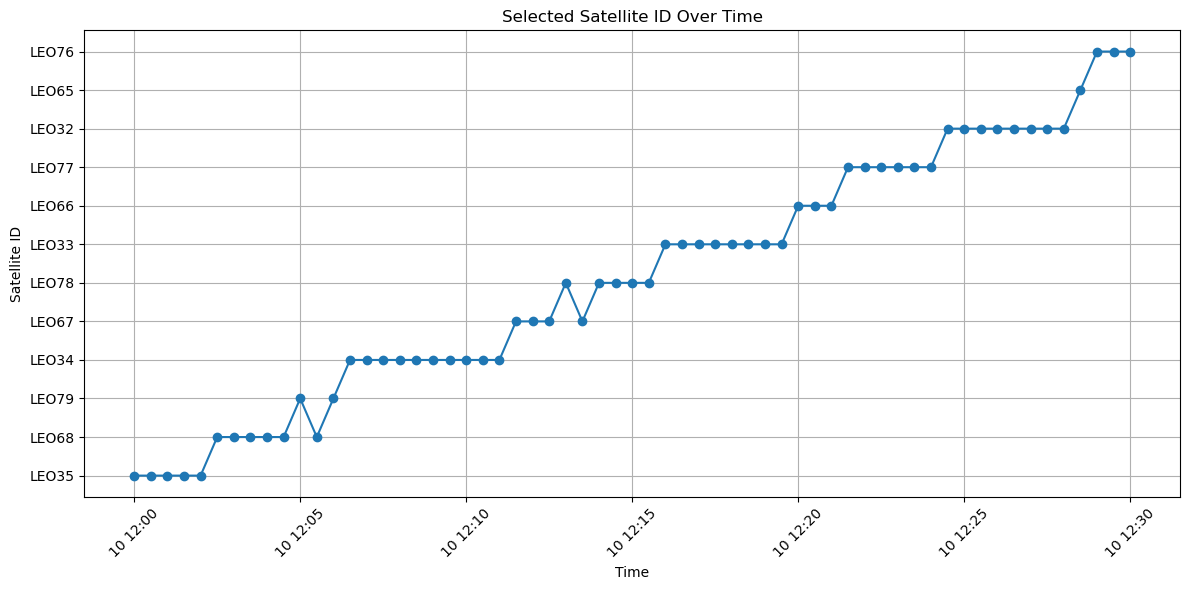

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Time is in datetime format if needed
final_df['Time'] = pd.to_datetime(final_df['Time'])

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(final_df['Time'], final_df['Best_SAT_ID'], marker='o', linestyle='-', color='tab:blue')

plt.title("Selected Satellite ID Over Time")
plt.xlabel("Time")
plt.ylabel("Satellite ID")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()
